In [220]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import BaggingClassifier
import shap
import lime
import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer
import random

***EXPLORATORY DATA ANALYSIS***

In [221]:
# Read in dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [222]:
#Show first 5 rows
df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

In [223]:
#Check missing values
print("The number of NULL values:")
df.isnull().sum()

The number of NULL values:


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

***Attribute Information - Thirteen (13 = 12 + 1) clinical features:***
- age: age of the patient (years)
- anemia: decrease of red blood cells or hemoglobin (boolean) 
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L) 
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary) 
- serum creatinine: level of serum creatinine in the blood (mg/dL) 
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient deceased during the follow-up period (boolean)

In [224]:
# Check how many values for each attribute to see if it matches the description, attributes with 2 values are boolean
print("The number of unique values for each attributes:")
df.nunique()

The number of unique values for each attributes:


age                          47
anaemia                       2
creatinine_phosphokinase    208
diabetes                      2
ejection_fraction            17
high_blood_pressure           2
platelets                   176
serum_creatinine             40
serum_sodium                 27
sex                           2
smoking                       2
time                        148
DEATH_EVENT                   2
dtype: int64

In [225]:
#Lists of categorical columns and numerical columns
cat_cols =['anaemia','diabetes','high_blood_pressure','sex','smoking']
num_cols = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']

In [226]:
#Summary Statistics of Numerical data
num_df = df[num_cols]
print("Statistical Summary of the numerical variables:")
num_df.describe().round(2)

Statistical Summary of the numerical variables:


age  creatinine_phosphokinase  ejection_fraction  platelets  \
count  299.00                    299.00             299.00     299.00   
mean    60.83                    581.84              38.08  263358.03   
std     11.89                    970.29              11.83   97804.24   
min     40.00                     23.00              14.00   25100.00   
25%     51.00                    116.50              30.00  212500.00   
50%     60.00                    250.00              38.00  262000.00   
75%     70.00                    582.00              45.00  303500.00   
max     95.00                   7861.00              80.00  850000.00   

       serum_creatinine  serum_sodium    time  
count            299.00        299.00  299.00  
mean               1.39        136.63  130.26  
std                1.03          4.41   77.61  
min                0.50        113.00    4.00  
25%                0.90        134.00   73.00  
50%                1.10        137.00  115.00  
75%                1.40        140.00  203.00  
max                9.40        148.00  285.00

In [227]:
#Count boolean values of categorical (boolean/binary) columns
cat_df = df[cat_cols]
cat_counts = cat_df.apply(pd.value_counts).transpose()

- 1 = Yes
- 0 = No
- 1 = Male, 0 = Female

<Figure size 640x480 with 0 Axes>

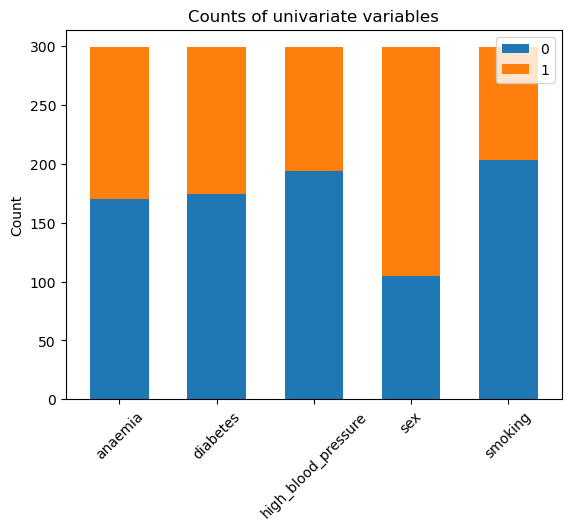

In [228]:
# Plot the stacked bar chart
plt.figure()
cat_counts.plot(kind='bar', stacked=True, width=0.6)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Counts of univariate variables')
plt.legend()
plt.show()

In [229]:
percentage=[]
print("Percentage of Univariate variables:")
for i in cat_cols:
    percentage = (df[i] == 1).sum() / len(df) * 100
    print(i, ':', percentage.round(2),'%')

Percentage of Univariate variables:
anaemia : 43.14 %
diabetes : 41.81 %
high_blood_pressure : 35.12 %
sex : 64.88 %
smoking : 32.11 %


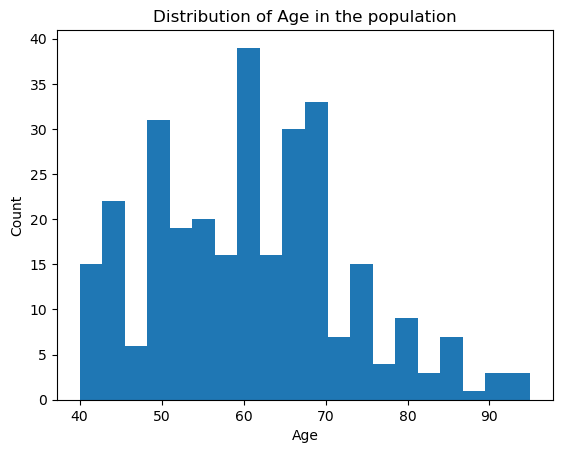

In [230]:
#Distribution of Age in the population
plt.hist(df['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age in the population')
plt.show()

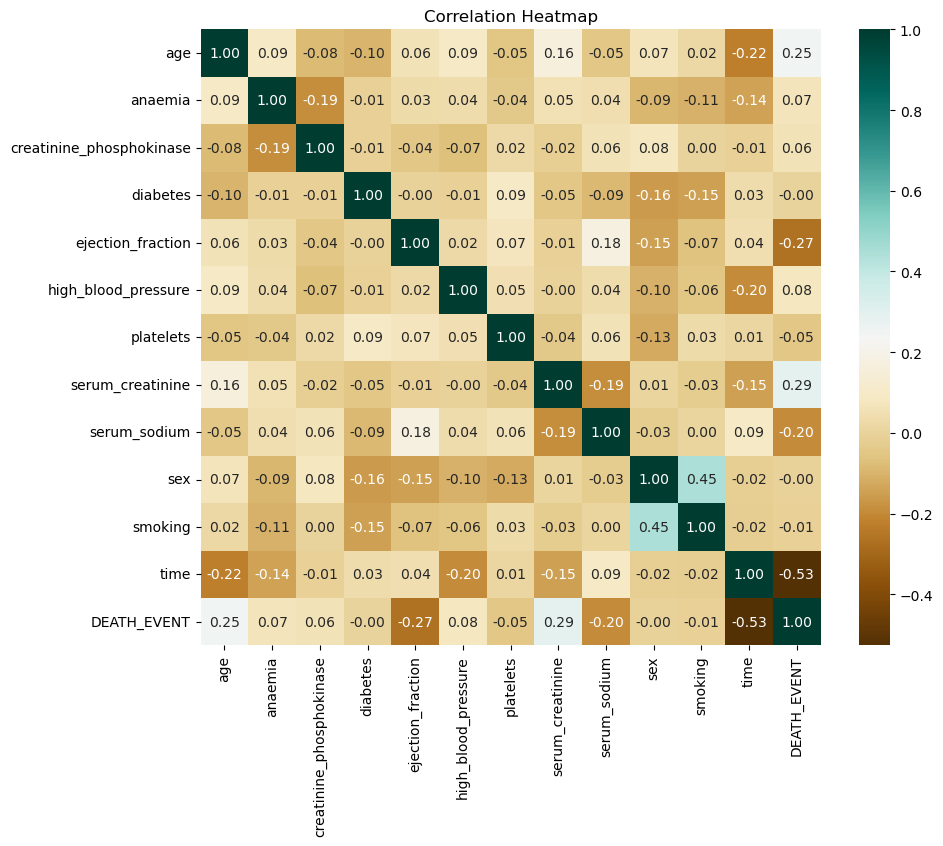

In [231]:
# Correlation Heat Map
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()

***ANALYSIS***
Correlation Heatmap shows the relationship among pairs of attributes. In this case, the darker brown or darker green color shows a strong correlation between 2 attributes. The 4 attributes that have the strongest correlation with "Death_Event" column are: age, ejection_fraction, serum_creatinine, and time.

/var/folders/kh/nhc2z66x4znd8j227lnt58kc0000gn/T/ipykernel_42363/1998340272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df['DEATH_EVENT'] = df['DEATH_EVENT']


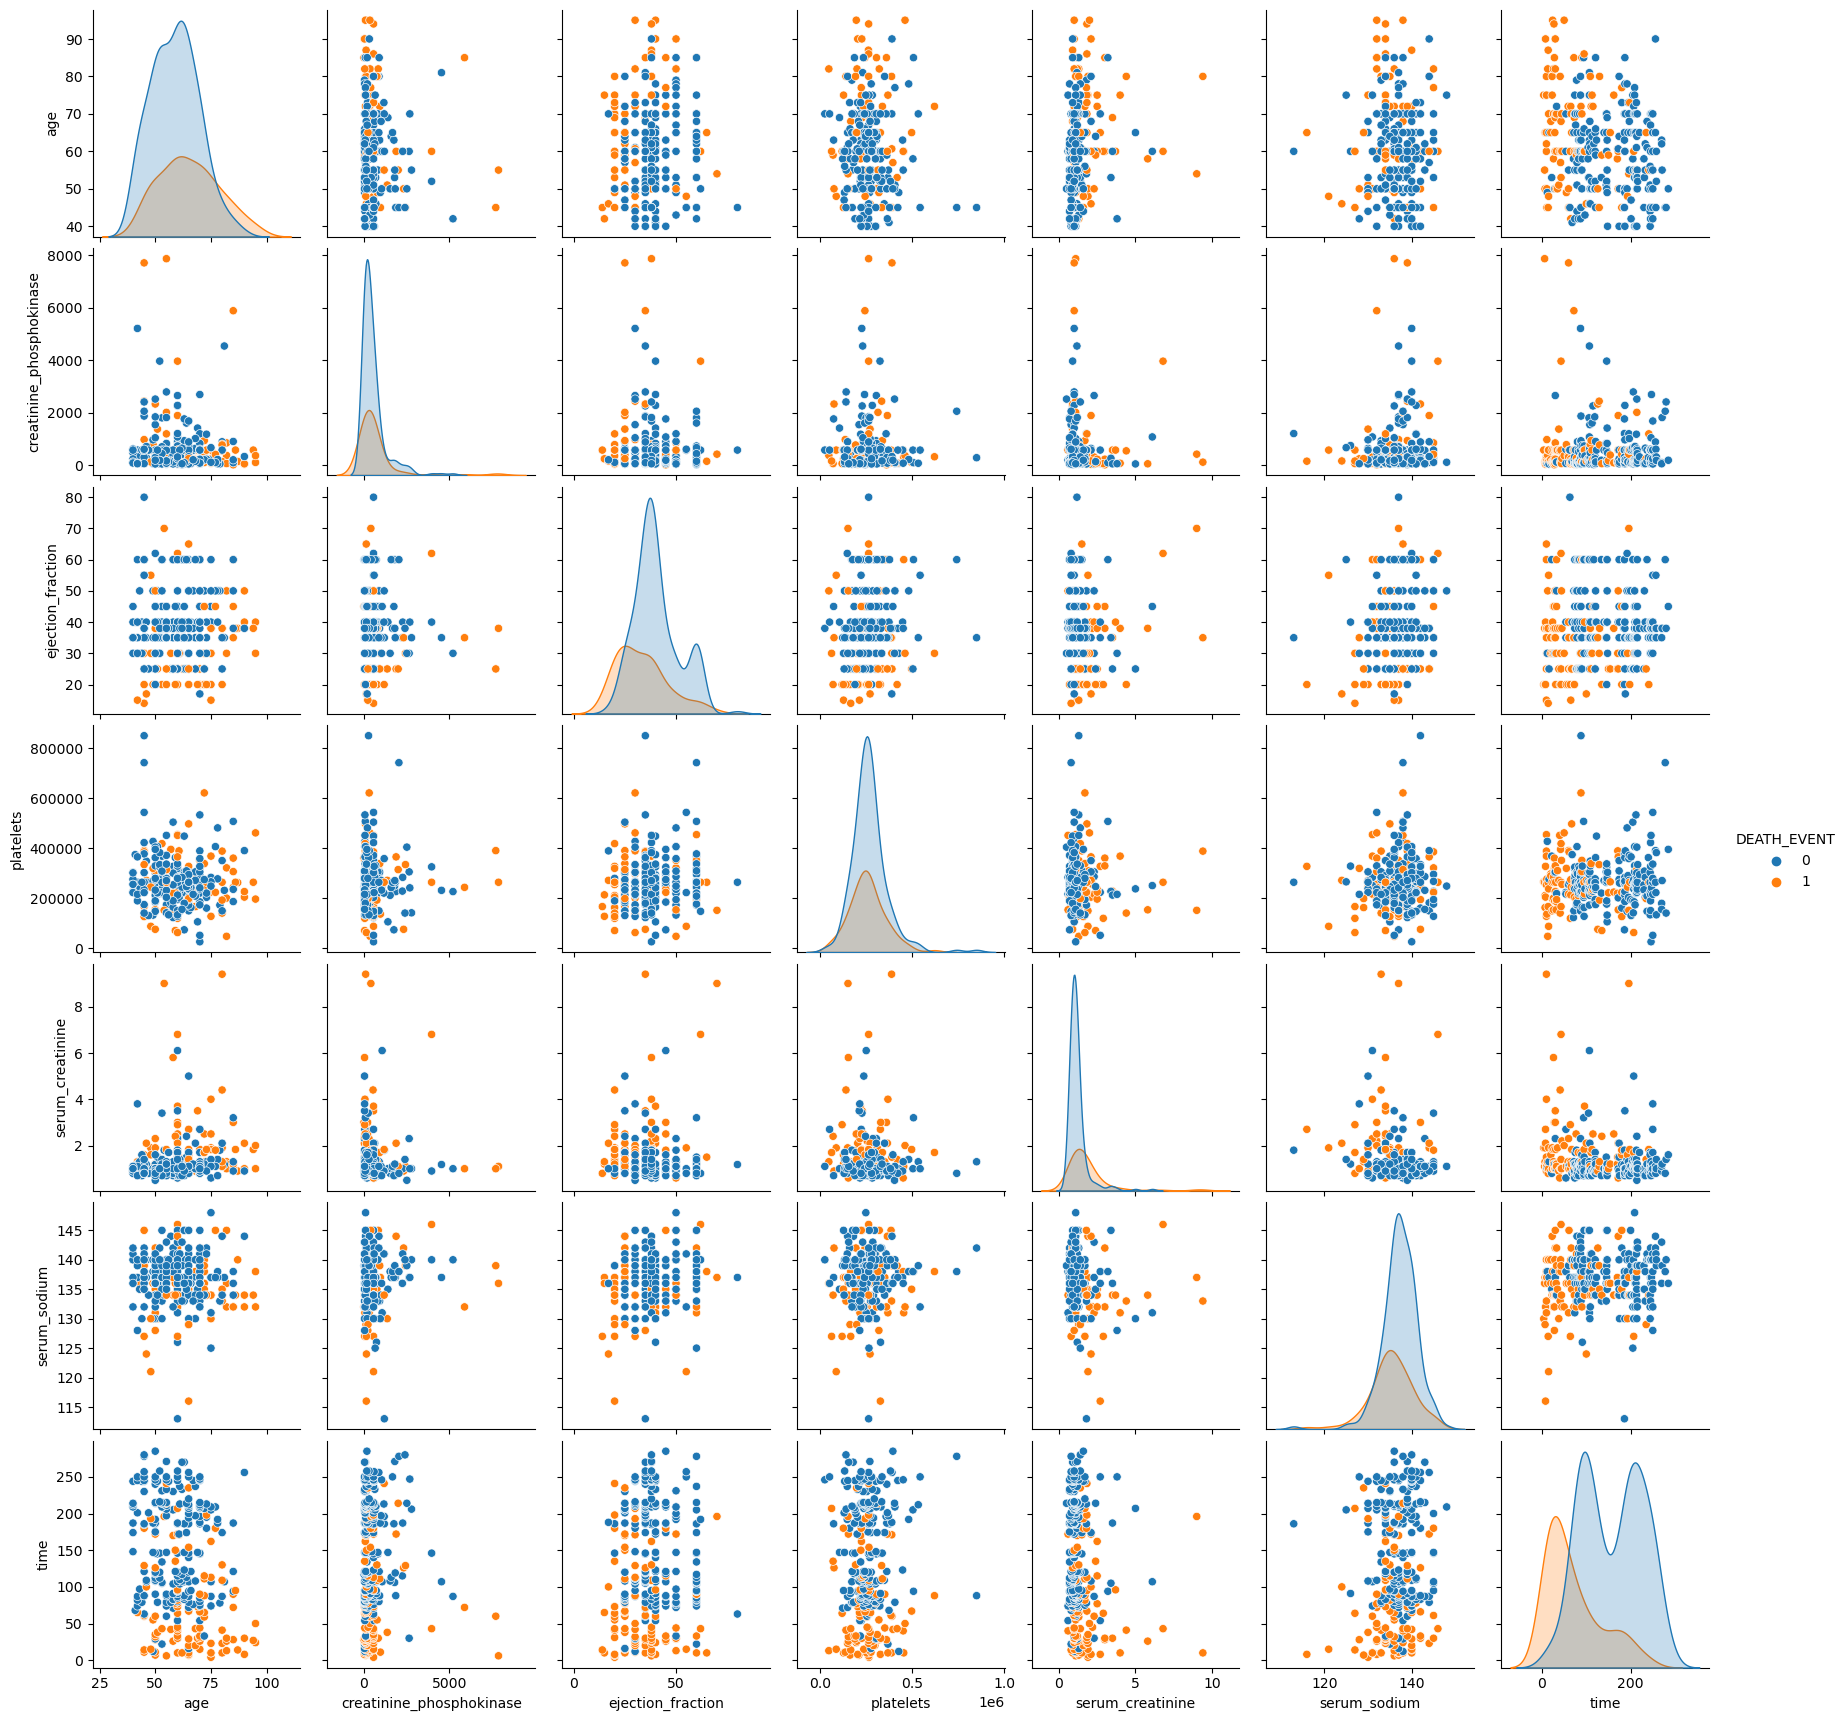

In [232]:
num_df['DEATH_EVENT'] = df['DEATH_EVENT']
# Pairplot to show relationship among pairs of attributes
sns.pairplot(num_df, hue='DEATH_EVENT')
plt.show()

***ANALYSIS***
Pairplot explores the relationship between numerical variables through visualization technique.
There's no clearly strong relationship between the variables except one:
heart failure scatters almost evenly over all ages, creatinine, ejection, platelets, serum creatinine, serum sodium, however, it looks like the more days in one's follow-up period, the less likely they will die from heart failure, based on this data.

In [233]:
#Compare mean values of all variables by DEATH_EVENT i.e, the difference between the people who died and survived of heart failure
death_survive = df.groupby("DEATH_EVENT").mean().round(4)
death_survive

age  anaemia  creatinine_phosphokinase  diabetes  \
DEATH_EVENT                                                         
0            58.7619   0.4089                  540.0542    0.4187   
1            65.2153   0.4792                  670.1979    0.4167   

             ejection_fraction  high_blood_pressure    platelets  \
DEATH_EVENT                                                        
0                      40.2660               0.3251  266657.4899   
1                      33.4688               0.4062  256381.0448   

             serum_creatinine  serum_sodium     sex  smoking      time  
DEATH_EVENT                                                             
0                      1.1849      137.2167  0.6502   0.3251  158.3399  
1                      1.8358      135.3750  0.6458   0.3125   70.8854

In [234]:
#Create dataframes of people who have diabetes, high blood pressure and anaemia
diabetes_df = df[df["diabetes"]==1]
highblood_df = df[df["high_blood_pressure"]==1]
anaemia_df = df[df["anaemia"]==1]

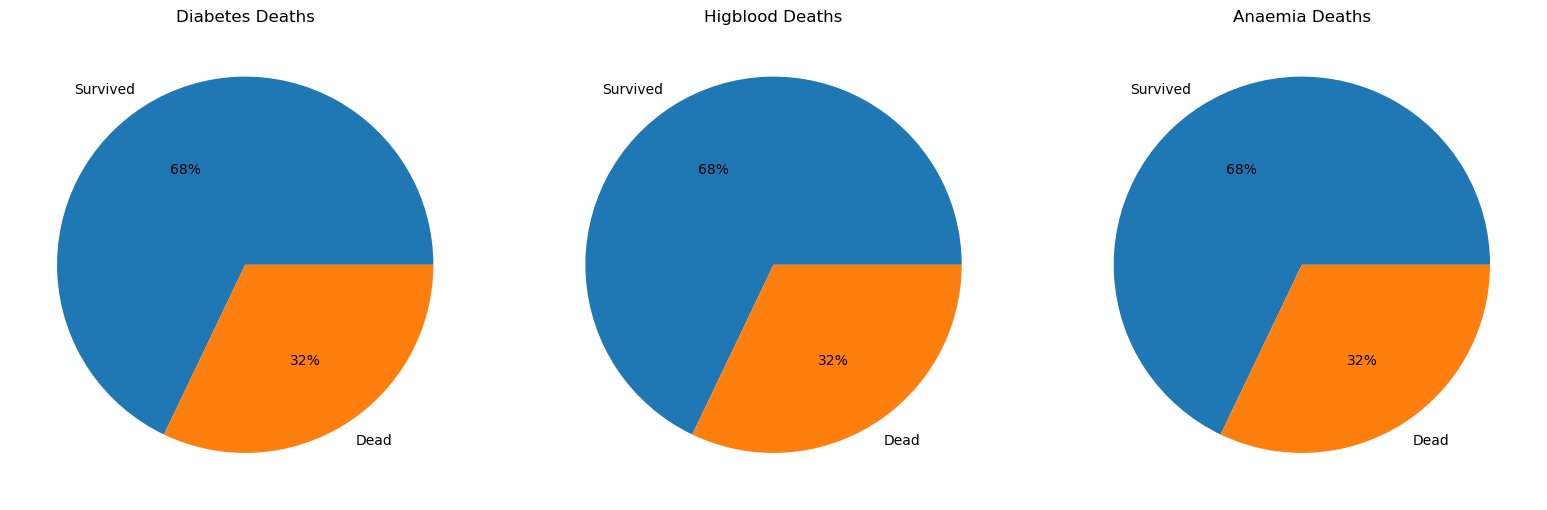

In [235]:
#Pie chart of percentages of people died that have these conditions
fig,axes = plt.subplots(1,3,figsize=(16,16))

fig.tight_layout()

axes[0].set_title("Diabetes Deaths");
axes[0].pie(df["DEATH_EVENT"].value_counts(),labels=["Survived","Dead"], autopct='%2.f%%');

axes[1].set_title("Higblood Deaths");
axes[1].pie(df["DEATH_EVENT"].value_counts(),labels=["Survived","Dead"], autopct='%2.f%%');

axes[2].set_title("Anaemia Deaths");
axes[2].pie(df["DEATH_EVENT"].value_counts(),labels=["Survived","Dead"], autopct='%2.f%%');

***ANALYSIS***
Having conditions like diabetes, high blood pressure and anaemia might increase the chance of heart failure mortality by up to 32%

In [236]:
#Create dataframe with heart failure deaths
death_df = df[df['DEATH_EVENT']==1]

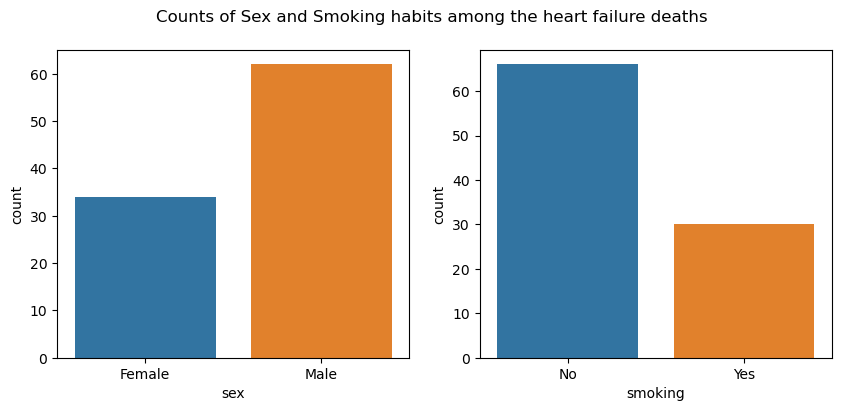

In [237]:
#Analyzing in the death dataset, the counts of female vs. male, smokers vs. non-smokers
fig,axes = plt.subplots(1,2,figsize=(10,4))

sns.countplot(x='sex', data=death_df,ax=axes[0])
axes[0].set_xticklabels(['Female', 'Male'])

sns.countplot(x='smoking', data=death_df,ax=axes[1])
axes[1].set_xticklabels(['No', 'Yes'])

plt.suptitle("Counts of Sex and Smoking habits among the heart failure deaths")
plt.show()

***ANALYSIS*** Men are more likely to die from heart failure than women and 30% of people who died from heart failure are smokers

***DATA MODELING***

In [288]:
#Split dataset into feature and target variables
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

LOGISTIC REGRESSION

In [289]:
# Create a logistic regression model
logistic = LogisticRegression()

# Instantiate GridSearchCV
logistic_gs = GridSearchCV(logistic, 
                           {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                           scoring=['accuracy', 'roc_auc'],
                           refit='accuracy')

# Fit GridSearchCV to the training data
logistic_gs.fit(X_train_scaled, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit='accuracy', scoring=['accuracy', 'roc_auc'])

In [290]:
print("Best parameters found:", logistic_gs.best_params_)

# Evaluate the best model on the test data
best_logistic = logistic_gs.best_estimator_
y_pred1 = best_logistic.predict(X_test_scaled)
accuracy_score1 = accuracy_score(y_test, y_pred1).round(4)
print("Accuracy of the best Logistic Regression model:", accuracy_score1)

Best parameters found: {'C': 0.1}
Accuracy of the best Logistic Regression model: 0.85


Auc-roc Score: 0.8796


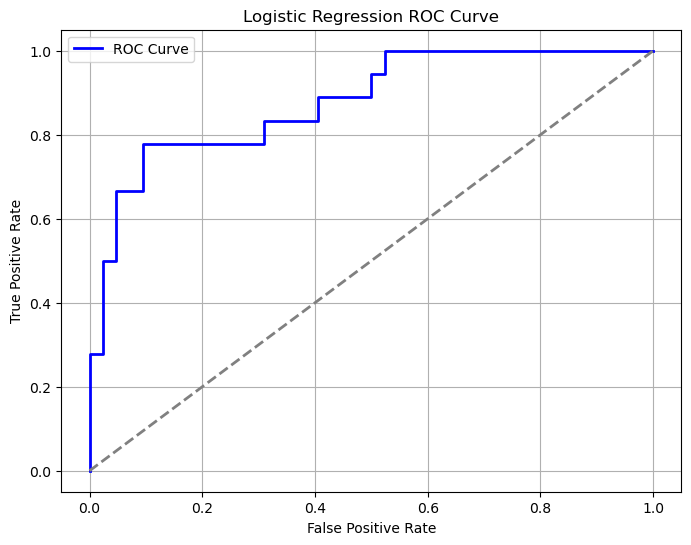

In [291]:
# Generate ROC curve
y_prob1 = best_logistic.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob1)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.grid(True)
auc_score1 = roc_auc_score(y_test, y_prob1)
print("Auc-roc Score:", auc_score1.round(4))
plt.show()

DECISION TREE

In [292]:
#Create a decision tree model
tree = DecisionTreeClassifier()

# Instantiate GridSearchCV
tree_gs = GridSearchCV(tree,
                       {'criterion': ['gini', 'entropy'],
                        'max_depth': [None, 5, 10, 15],
                        'min_samples_split': [2, 5, 10]},
                       scoring=['accuracy', 'roc_auc'],
                       refit='accuracy')

# Fit GridSearchCV to the training data
tree_gs.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'min_samples_split': [2, 5, 10]},
             refit='accuracy', scoring=['accuracy', 'roc_auc'])

In [293]:
print("Best parameters found:", tree_gs.best_params_)

# Evaluate the best model on the test data
best_tree = tree_gs.best_estimator_
y_pred2 = best_tree.predict(X_test)
accuracy_score2 = accuracy_score(y_test, y_pred2).round(4)
print("Accuracy of the best Decision Tree model:", accuracy_score2)

Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}
Accuracy of the best Decision Tree model: 0.7667


Auc-roc Score: 0.8148


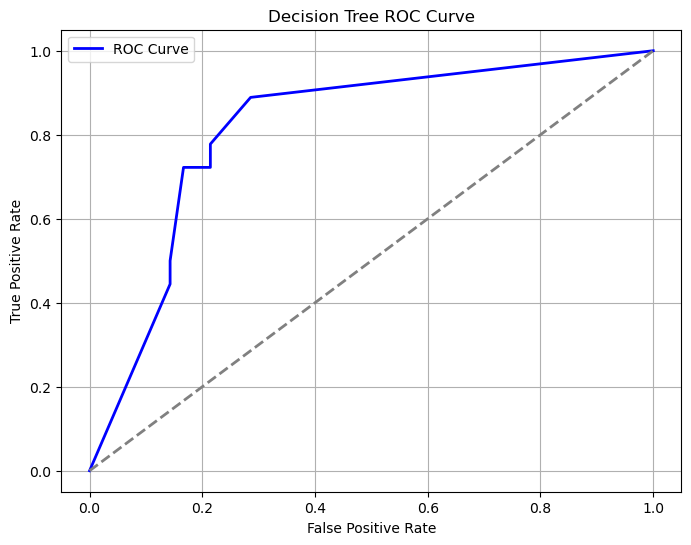

In [294]:
# Generate ROC curve
y_prob2 = best_tree.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob2)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend()
plt.grid(True)
auc_score2 = roc_auc_score(y_test, y_prob2)
print("Auc-roc Score:", auc_score2.round(4))
plt.show()

***RANDOM FOREST***

In [295]:
#Create a random forest model
forest = RandomForestClassifier()

# Instantiate GridSearchCV
forest_gs = GridSearchCV(forest,
                       {'n_estimators': [100,200,300],
                        'max_depth': [None, 5, 10, 15]},
                       scoring=['accuracy','roc_auc'],
                        refit='accuracy')

# Fit GridSearchCV to the training data
forest_gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             refit='accuracy', scoring=['accuracy', 'roc_auc'])

In [296]:
print("Best parameters found:", forest_gs.best_params_)

# Evaluate the best model on the test data
best_forest = forest_gs.best_estimator_
y_pred3 = best_forest.predict(X_test)
accuracy_score3 = accuracy_score(y_test, y_pred3).round(4)
print("Accuracy of the best Random Forest model:", accuracy_score3)

Best parameters found: {'max_depth': None, 'n_estimators': 100}
Accuracy of the best Random Forest model: 0.8667


Auc-roc Score: 0.9067


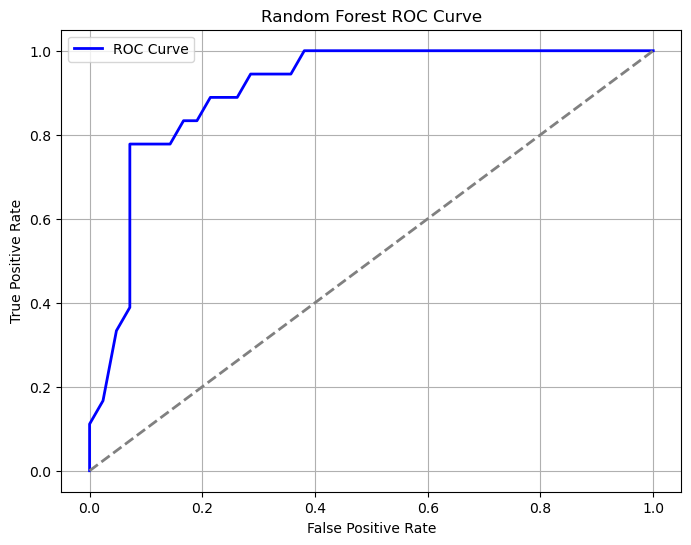

In [297]:
# Generate ROC curve
y_prob3 = best_forest.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob3)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.grid(True)
auc_score3 = roc_auc_score(y_test, y_prob3)
print("Auc-roc Score:", auc_score3.round(4))
plt.show()

***XGBOOST***

In [305]:
#Create a XGBoost model
xgb = XGBClassifier()

# Instantiate GridSearchCV
xgb_gs = GridSearchCV(xgb,
                       {'n_estimators': [100, 200, 300],
                        'max_depth': [3, 5, 7],
                        'learning_rate': [0.01, 0.1, 0.2]},
                      scoring=['accuracy','roc_auc'],
                      refit='roc_auc')

# Fit GridSearchCV to the training data
xgb_gs.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'])

In [306]:
print("Best parameters found:", xgb_gs.best_params_)

# Evaluate the best model on the test data
best_xgb = xgb_gs.best_estimator_
y_pred4 = best_xgb.predict(X_test)
accuracy_score4 = accuracy_score(y_test, y_pred4).round(4)
print("Accuracy of the best XGBoost model:", accuracy_score4)

Best parameters found: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Accuracy of the best XGBoost model: 0.85


Auc-roc Score: 0.9048


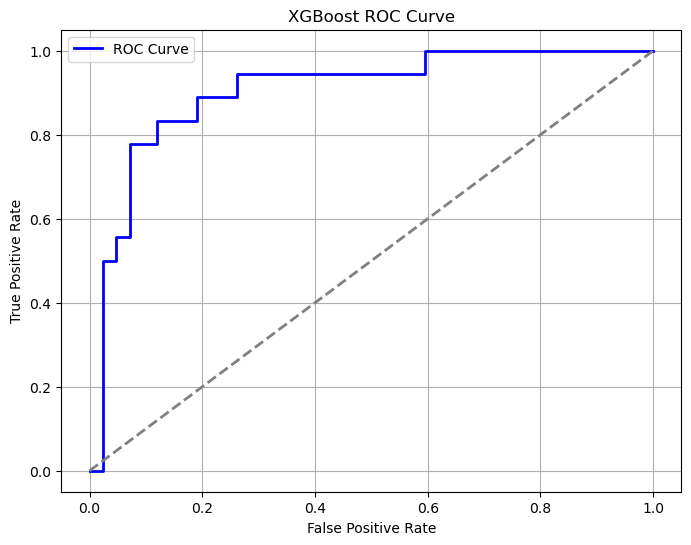

In [307]:
# Generate ROC curve
y_prob4 = best_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob4)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend()
plt.grid(True)
auc_score4 = roc_auc_score(y_test, y_prob4)
print("Auc-roc Score:", auc_score4.round(4))
plt.show()

In [308]:
#Create a dataframe with all models' evaluation metrics
models= ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
auc_scores = [auc_score1, auc_score2, auc_score3, auc_score4]
accuracy_scores = [accuracy_score1, accuracy_score2, accuracy_score3,accuracy_score4]
    
model_performance = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'ROC_AUC': auc_scores
})
print("Evaluation metrics for each model:")
print(model_performance.sort_values(['Accuracy', 'ROC_AUC'], ascending=False))

Evaluation metrics for each model:
                 Model  Accuracy   ROC_AUC
2        Random Forest    0.8667  0.906746
3              XGBoost    0.8500  0.904762
0  Logistic Regression    0.8500  0.879630
1        Decision Tree    0.7667  0.814815


***ANALYSIS***
Overall, all the models came back with high accuracy and roc auc scores. Random Forest yielded the best among all. The farther the ROC curve is from the diagonal line towards the top-left corner, the better the model performance, meaning the model's ability to distinguish between positive and negative cases across different classification thresholds and Random Forest model has proven this best among all the models. 

***MACHINE LEARNING INTERPRETABILITY/EXPLANABILITY***

***ELI5'S INTERPRETATION OF LOGISTIC REGRESSION MODEL - FEATURE WEIGHTS***

I used the model with the best params found by GridSearchCV earlier

In [309]:
all_cols = cat_cols + num_cols

print("Weights associated with each feature using Logistic Regression model:")
eli5.show_weights(best_model, feature_names = all_cols)

Weights associated with each feature using Logistic Regression model:


This figure shows in descending order of how much a variable contribute to the outcome of the target label

In [310]:
#Explain specific predictions

# Pick a row in the test data with a negative label (DEATH_EVENT = 0)
negative_row = X_test_scaled[y_test == 0][0]
print("Negative Row picked:")
print(negative_row)
eli5.show_prediction(best_logistic, negative_row,feature_names=all_cols, show_feature_values=True)

Negative Row picked:
[ 0.33668367 -0.86285894 -0.36519241  1.16890403  1.01235688 -0.73616267
 -1.22021473 -0.06967475  0.10632867  0.74972762  1.52297224 -0.75191059]


In [311]:
# Pick a row in the test data with a positive label (DEATH_EVENT = 1)
positive_row = X_test_scaled[y_test == 1][0]  
print("Positive Row picked:")
print(positive_row)
eli5.show_prediction(best_logistic, positive_row, feature_names=all_cols, show_feature_values=True)

Positive Row picked:
[ 2.73171132 -0.86285894 -0.0153414   1.16890403 -0.01504564  1.35839541
  0.01802896  0.49972532 -0.56242268  0.74972762 -0.65661079 -1.328962  ]


***ELI5'S INTERPRETATION OF DECISION TREE MODEL - FEATURE IMPORTANCE***

I used the model with the best params found by GridSearchCV earlier

In [312]:
perm = PermutationImportance(best_tree).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=all_cols)

This figure shows the importance of the features to the target variable in descending order. I also used permutation importance model to better understand the interaction and effects among varriables. 

In [313]:
#Explain specific predictions
# Pick a row in the test data with a negative label (DEATH_EVENT = 0)
negative_row_tree = X_test[y_test == 0].iloc[0]
print("Negative Row picked:")
print(negative_row_tree)
eli5.explain_prediction(best_tree, negative_row_tree,feature_names=all_cols)

Negative Row picked:
age                             65.0
anaemia                          0.0
creatinine_phosphokinase       224.0
diabetes                         1.0
ejection_fraction               50.0
high_blood_pressure              0.0
platelets                   149000.0
serum_creatinine                 1.3
serum_sodium                   137.0
sex                              1.0
smoking                          1.0
time                            72.0
Name: 73, dtype: float64


Explanation(estimator="DecisionTreeClassifier(criterion='entropy', min_samples_split=10)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='time', weight=0.535709132881258, std=None, value=72.0), FeatureWeight(feature='<BIAS>', weight=0.3263598326359833, std=None, value=1.0), FeatureWeight(feature='high_blood_pressure', weight=0.2222222222222222, std=None, value=224.0)], neg=[FeatureWeight(feature='platelets', weight=-0.08429118773946354, std=None, value=137.0)], pos_remaining=0, neg_remaining=0), proba=1.0, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [314]:
# Pick a row in the test data with a negative label (DEATH_EVENT = 1)
positive_row_tree = X_test[y_test == 1].iloc[0]
print("Positive Row picked:")
print(positive_row_tree)
eli5.explain_prediction(best_tree, positive_row_tree,feature_names=all_cols)

Positive Row picked:
age                             94.00
anaemia                          0.00
creatinine_phosphokinase       582.00
diabetes                         1.00
ejection_fraction               38.00
high_blood_pressure              1.00
platelets                   263358.03
serum_creatinine                 1.83
serum_sodium                   134.00
sex                              1.00
smoking                          0.00
time                            27.00
Name: 30, dtype: float64


Explanation(estimator="DecisionTreeClassifier(criterion='entropy', min_samples_split=10)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='time', weight=0.535709132881258, std=None, value=27.0), FeatureWeight(feature='<BIAS>', weight=0.3263598326359833, std=None, value=1.0), FeatureWeight(feature='platelets', weight=0.13793103448275867, std=None, value=134.0)], neg=[], pos_remaining=0, neg_remaining=0), proba=1.0, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

***LIME'S EXPLANATION FOR RANDOM FOREST AND XGBOOST MODEL***

In [315]:
#Create Explainer Instance
lime_explainer = LimeTabularExplainer(X_train.values, mode="classification", feature_names=all_cols)

In [316]:
# Explain predictions for Random Forest model
rf_exp = lime_explainer.explain_instance(X_test.values[random.randint(0, len(X_test))], best_forest.predict_proba, num_features=len(all_cols))

print("Random Forest Model:")
print("Coefficients:", rf_exp.local_exp)
print("Intercept:", rf_exp.intercept[1].round(4))
print("R2 Score:", rf_exp.score.round(4))
print(rf_exp.show_in_notebook(show_table=True))

Random Forest Model:
Coefficients: {1: [(4, 0.1739021754404514), (11, -0.14067539846593333), (7, -0.08490566396336835), (0, -0.03793953814802548), (8, -0.029309031670812814), (6, 0.021326897041218425), (1, -0.007435392317642241), (3, 0.00710800315116463), (2, -0.0021252766506720438), (10, 0.001980041458372212), (9, -0.0016232952621466259), (5, -0.00127705925482141)]}
Intercept: 0.3857
R2 Score: 0.1874


/Users/thaonguyen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


None


In [317]:
# Explain predictions for XGBoost model
xgb_exp = lime_explainer.explain_instance(X_test.values[random.randint(0, len(X_test))], best_xgb.predict_proba, num_features=len(all_cols))

print("XGBoost Model:")
print("Coefficients:", xgb_exp.local_exp[1])
print("Intercept:", xgb_exp.intercept[1].round(4))
print("R2 Score:", xgb_exp.score.round(4))
print(xgb_exp.show_in_notebook(show_table=True))

XGBoost Model:
Coefficients: [(4, 0.2226940142320535), (11, -0.10831667160298082), (7, -0.07300107072968166), (5, 0.04171679281223494), (9, -0.0375036662654884), (0, -0.0363567920844025), (10, 0.027484030330459975), (1, 0.020504733383305888), (3, -0.019822138115491786), (2, 0.015341182840436743), (8, 0.013987322649308952), (6, 0.008894314153081567)]
Intercept: 0.305
R2 Score: 0.1004


None


The R2 score (coefficient of determination) measures the goodness of fit of the model.  An R2 score of 0.1004 suggests that the model explains 10.04% of the variance in the target variable, which is not desirable because anything less than 50% is not good.
The closer R2 is to 1, the better.

***SHAP'S INTERPRETATION OF XGBOOST MODEL***

In [318]:
# Create a tree explainer and calculate shap values for X_test
shap_explainer = shap.TreeExplainer(best_xgb)
shap_values = shap_explainer.shap_values(X_test)

Visualize explanations with force_plot

In [273]:
#Identify the positive and negative labels indices
pos_id = np.where(y_test ==1)
neg_id = np.where(y_test ==0)

In [319]:
#for positive prediction (label=1)
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[pos_id], X_test.iloc[pos_id])

In [275]:
#for negative prediction (label=0)
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[neg_id], X_test.iloc[neg_id])

Feature importance plot by SHAP’s ‘summary_plot’ function, for each class / label

SHAP Feature importance plot for Positive Class


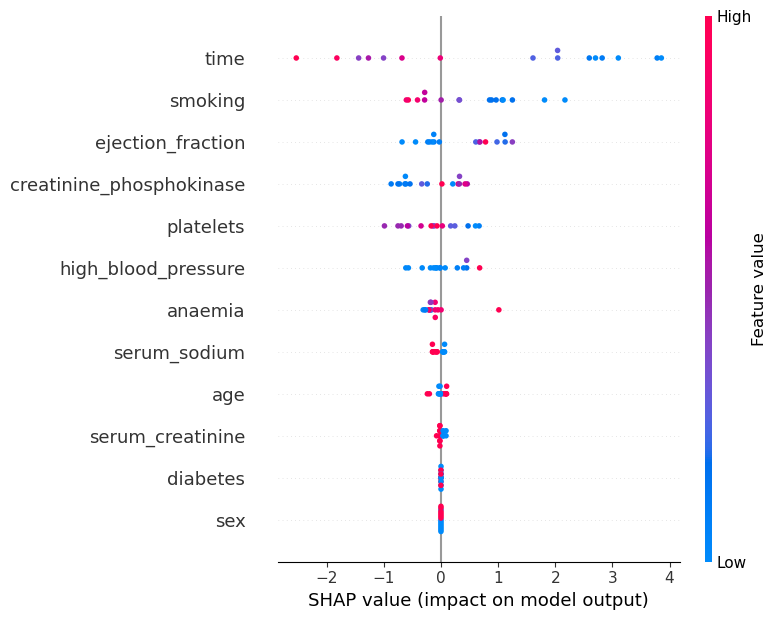

In [276]:
# Feature importance plot for each class/label
print("SHAP Feature importance plot for Positive Class")
shap.summary_plot(shap_values[pos_id], X_test.iloc[pos_id], feature_names=all_cols, title="Positive Class")

SHAP Feature importance plot for Negative Class


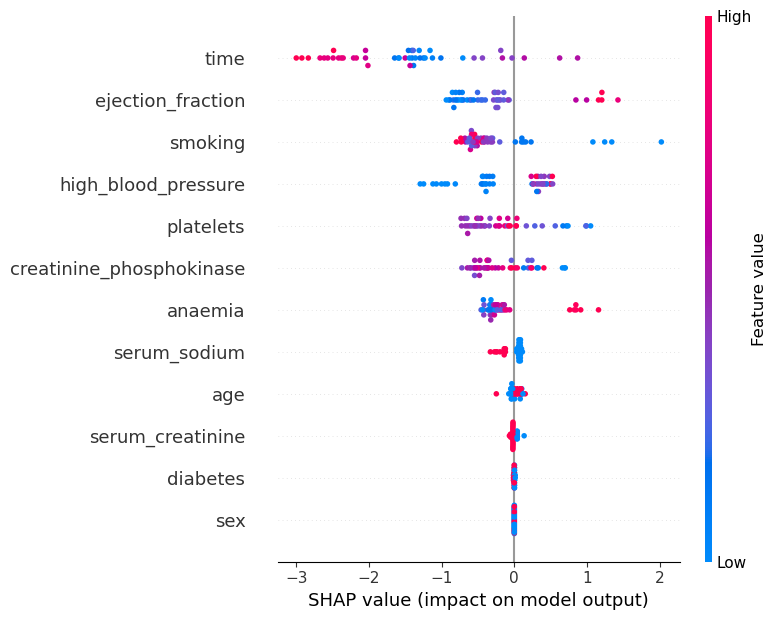

In [277]:
print("SHAP Feature importance plot for Negative Class")
shap.summary_plot(shap_values[neg_id], X_test.iloc[neg_id], feature_names=all_cols, title="Negative Class")

PREDICT OBSERVATIONS

In [320]:
model_list = {'LR':best_logistic,
          'DT':best_tree,
          'RF':best_forest,
          'XGB':best_xgb}

In [343]:
print("Accuracy for each model in format: Model: [prob_T prob_F]:")

#Run predict_proba on X_test and get the labels based on highest probability (argmax) 
#and get accuracy score using that label list and y_test

for name, model in model_list.items():
    if model == best_logistic:
        probs = model.predict_proba(X_test_scaled)
    else:
        probs = model.predict_proba(X_test)
        
    predicted = probs.argmax(axis=1)
    accuracy = accuracy_score(y_test, predicted)
    print(name + ': [{} {}]'.format(accuracy.round(4), (1-accuracy).round(4)))

Accuracy for each model in format: Model: [prob_T prob_F]:
LR: [0.85 0.15]
DT: [0.7667 0.2333]
RF: [0.8667 0.1333]
XGB: [0.85 0.15]


Random Forest has the highest accuracy